In [ ]:
%matplotlib inline

# Face recognition example using eigenfaces and SVMs

In this exercise we'll explore how to extract feature vectors from an image dataset and run PCA and tSNE visualization. We will use a subset of 20 faces from the "Labeled Faces in the Wild" dataset (link below). Each class corresponds to a single person identity and there are 200 images per person, where each image is size 64 x 64. The goal is to find a feature vector that will effectively group images together belonging to the same person class.

You have been provided code that computes PCA and tSNE visualiztion on the raw pixels. Add a new feature type, histogram of gradients, and see whether it provides better results.

&nbsp;

Link to dataset:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

&nbsp;

**TODO's**:

1. Add a new feature - Histogram of Gradients (HOG)
2. Compute and plot PCA and tSNE for both features (pixels and HOG)
3. Compute and plot tSNE on the first 10 PCA components of the pixel features and compare to HOG tSNE

**Discussion Q's**:
- Why are the results for HOG features better than raw pixel features?
- Why does PCA dimensionality reduction improve the results for raw pixels?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.datasets import fetch_olivetti_faces
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# load the labeled face in wild dataset from sklearn

In [ ]:
# the min_faces_per_person dictates the number of classes
lfw_people = fetch_olivetti_faces()

# the label to predict is the id of the person
y = lfw_people.target

# keep only 20 classes
lfw_people.images = lfw_people.images[y<20, ...]
y = y[y<20]

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

n_classes = len(np.unique(y))

print("Total dataset size:")
print(f"n_samples, height, width: {n_samples}, {h}, {w}")
print("n_classes: %d" % n_classes)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Total dataset size:
n_samples, height, width: 200, 64, 64
n_classes: 20


# extract features from images

In [ ]:
def get_features(in_imgs, feat_name='pixels'):

  if feat_name == 'pixels':
    # stack flattened images into array
    featurelist = []
    for i in range (in_imgs.shape[0]):
      featurelist.append(in_imgs[i, :, :].flatten()[np.newaxis, :])
    features = np.vstack(featurelist)

    # plot the first image
    plt.figure(figsize=(5,5))
    plt.imshow(in_imgs[0, ...], cmap='gray')
    plt.axis('off')
    plt.show()
    return features

  if feat_name == 'hog':
    # stack extracted hog features into array
    # also save the first hog image for plotting
    featurelist = []
    hog_example = None
    for i in range(in_imgs.shape[0]):
        fd, hog_image = hog(in_imgs[i, :, :], orientations=4, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        if i == 0:
          hog_example = hog_image
        featurelist.append(fd[np.newaxis, :])
    features = np.vstack(featurelist)

    plt.figure(figsize=(5,5))
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return features

  return None


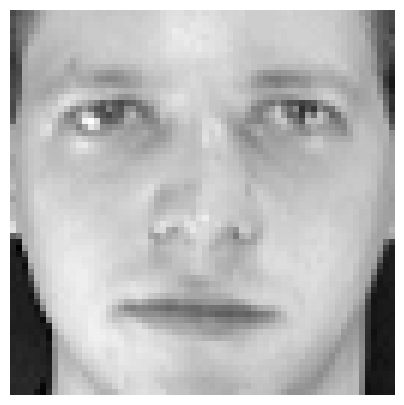

(200, 4096)


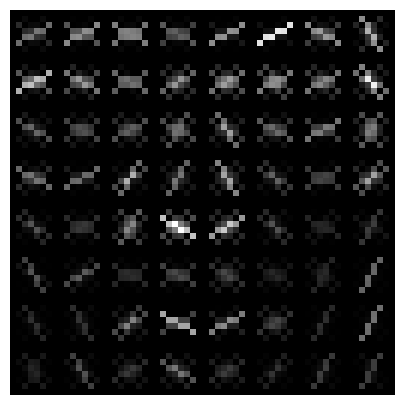

(200, 784)


In [ ]:
# plot example features

pixel_features = get_features(lfw_people.images, feat_name='pixels')
print(pixel_features.shape)

hog_features = get_features(lfw_people.images, feat_name='hog')
print(hog_features.shape)

# dimensionality reduction

In [ ]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)

  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-']
  labels = ['pixel features', 'hog features']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.grid(True)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

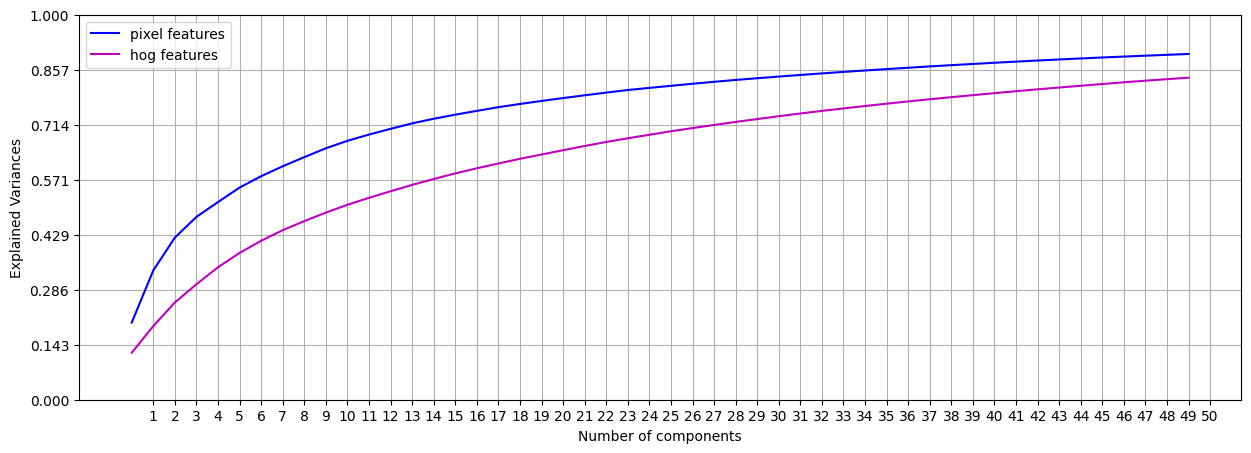

In [ ]:
# plot explained variance vs the number of components for PCA
x = plot_PCA([pixel_features, hog_features], n_components=50)

In [ ]:
# dimensionality reduction
X_pixels_pca, X_hog_pca = get_PCA([pixel_features, hog_features], n_components=2)[-1]
X_pixels_tsne, X_hog_tsne = get_tsne([pixel_features, hog_features], n_components=2)

# visualize discriminability of features in 2D

In [ ]:
def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in range(len(np.unique(y))):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

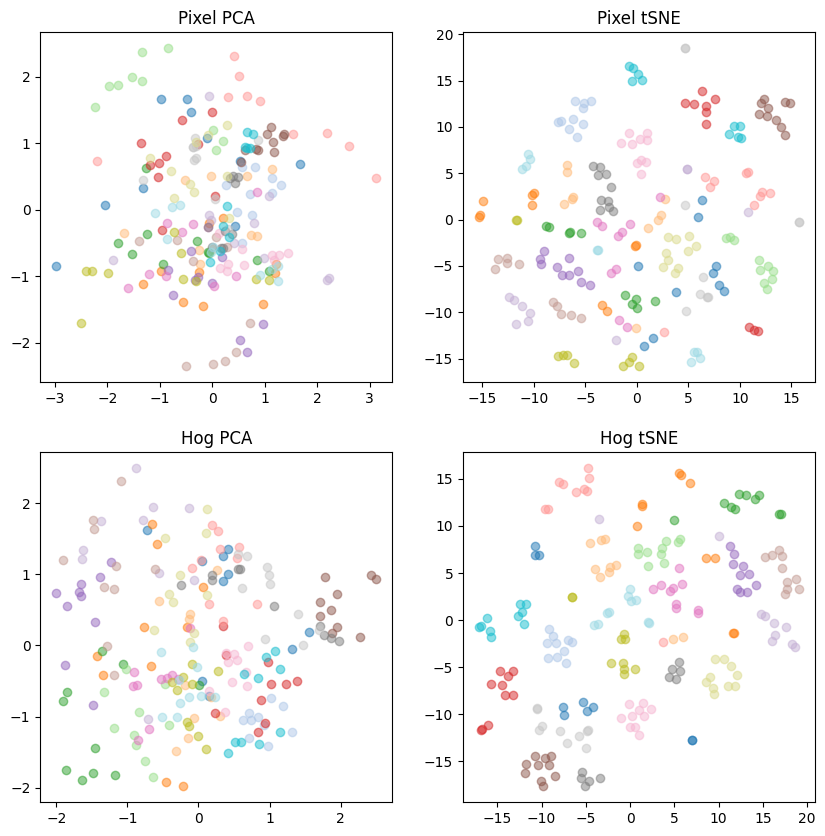

In [ ]:
# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# y is the class labels (person ID)
plot_classes( X_pixels_pca, y, ax[0,0], title='Pixel PCA')
plot_classes(X_pixels_tsne, y, ax[0,1], title='Pixel tSNE')

plot_classes( X_hog_pca, y, ax[1,0], title='Hog PCA')
plot_classes(X_hog_tsne, y, ax[1,1], title='Hog tSNE')

plt.show()

# visualize discriminability improvement with PCA

In [ ]:
# apply tSNE to only top 10 PCA components of pixel features
X_pixels_PCA_tsne = get_tsne([get_PCA([pixel_features], n_components=10)[-1][0]], n_components=2)[0]

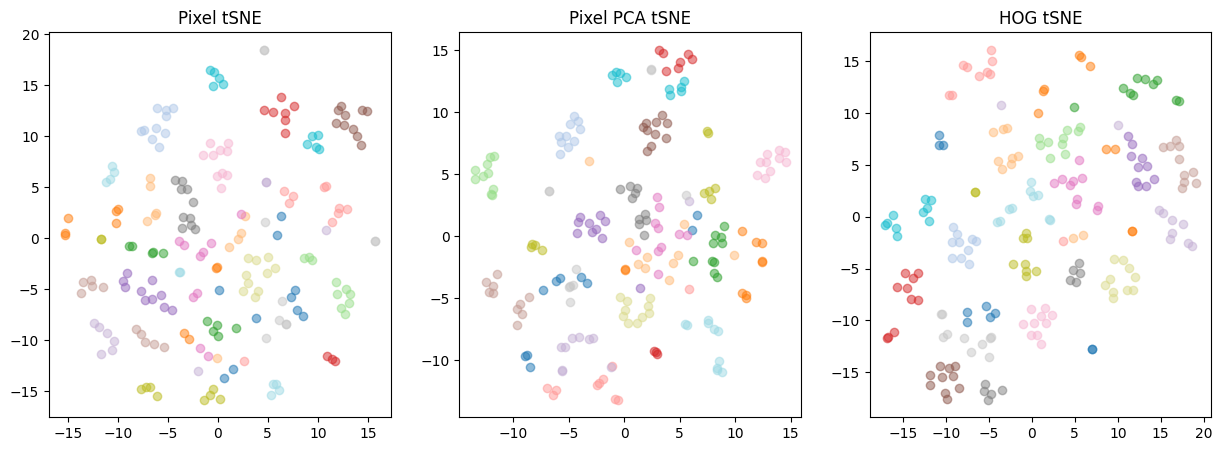

In [ ]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# y is the class labels
plot_classes(X_pixels_tsne, y, ax[0], title='Pixel tSNE')
plot_classes(X_pixels_PCA_tsne, y, ax[1], title='Pixel PCA tSNE')
plot_classes(X_hog_tsne, y, ax[2], title='HOG tSNE')
plt.show()